### Tuning hyperparameters with grid search

In this unit, we will see how to tune the hyperparameter using a simple technique called grid search. This time, we will work with the house prices data set.

In [2]:
import pandas as pd

# Load the data
data_df = pd.read_csv("c3_house-prices.csv")
data_df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


Let’s start by looking a the price.

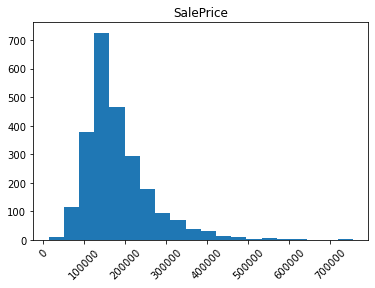

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

data_df.hist(column="SalePrice", bins=20, grid=False, xrot=45)
plt.show()

To avoid building a model that is biased toward more expensive houses, we will apply the logarithm transformation and build a model that predicts the log of the sale price.



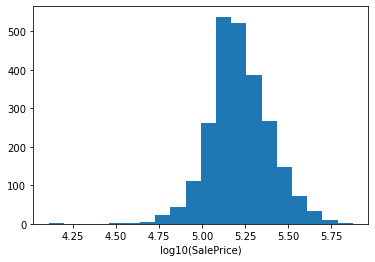

In [4]:
import numpy as np

plt.hist(np.log10(data_df.SalePrice), bins=20)
plt.xlabel("log10(SalePrice)")
plt.show()

#### Preprocessing the data
As often, the raw data isn’t ready for our machine learning algorithms. In the final project, you will work on this house prices data set and apply all the necessary data cleaning. However, for this unit, we will apply the minimal steps: encoding non-numerical entries with one-hot encoding, and replacing missing entries with the median value.

Let’s create a preprocess(df) function to perform those steps.

In [5]:
def preprocess(df):
    # Work on a copy
    df = df.copy()

    # One-hot encoding
    df = pd.get_dummies(df, dummy_na=True)

    # Fill missing values
    for c in df.columns:
        df[c] = df[c].fillna(df[c].median())

    return df


preprocessed_df = preprocess(data_df)
preprocessed_df.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_VWD,Sale Type_WD,Sale Type_nan,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial,Sale Condition_nan
0,484,528275070,60,68.0,8795,7,5,2000,2000,0.0,...,0,1,0,0,0,0,0,1,0,0
1,2586,535305120,20,75.0,10170,6,6,1951,1951,522.0,...,0,1,0,0,0,0,0,1,0,0
2,2289,923228250,160,21.0,2001,4,5,1970,1970,80.0,...,0,1,0,0,0,0,0,1,0,0
3,142,535152150,20,70.0,10552,5,5,1959,1959,0.0,...,0,1,0,0,0,0,0,1,0,0
4,2042,903475060,190,60.0,10120,7,4,1910,1950,0.0,...,0,1,0,0,0,0,0,1,0,0


As we can see, our preprocessed_df DataFrame contains all the numerical columns on the left and created the necessary one-hot encoded columns for non-numerical variables. The total number of feature is now 347.

Before applying the model, we still need to create the X/y variables and split the data into training/validation sets.

In [6]:
from sklearn.model_selection import train_test_split

# Create X, y
X = preprocessed_df.drop("SalePrice", axis=1).values
y = np.log10(preprocessed_df.SalePrice).values

# Split into train/validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.5, random_state=0)

print("Train:", X_tr.shape, y_tr.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (1215, 347) (1215,)
Validation: (1215, 347) (1215,)


The features have a different scale, so we also need to standardize them before applying ridge regression in the next part.



In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_val_rescaled = scaler.transform(X_val)

#### Linear regression
Before using ridge regression, let’s do a quick test and fit a linear regression model.



In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

# Try with a linear regression
lr = LinearRegression()
lr.fit(X_tr_rescaled, y_tr)

print("Train MSE: {:.4f}".format(MSE(y_tr, lr.predict(X_tr_rescaled))))
print("Validation MSE: {:.4f}".format(MSE(y_val, lr.predict(X_val_rescaled))))


Train MSE: 0.0014
Validation MSE: 39882370663790403387392.0000


As we can see, there is an issue with the model - the validation MSE score is extremely high. If we take a look at the model coefficients, we can see that they are extremely large.

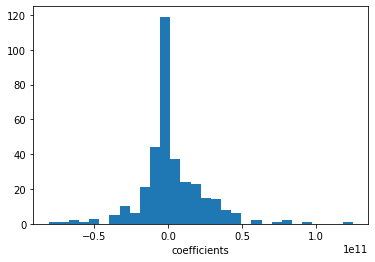

In [9]:
plt.hist(lr.coef_, bins=30)
plt.xlabel("coefficients")
plt.show()

Note the 1e11 factor on the x-axis (!) The high validation score probably comes from numerical issues due to those large coefficients. Let’s try to fix the issue with regularization!

Grid search
This time, we will search for the best regularization strength using a technique called grid search. You can think of this technique as a simple exhaustive searching over a set of hyperparameters.

In our case, we only have one hyperparameter: the regularization strength. So we will simply iterate over a list of alpha values and pick the one with the best validation score. However, in the next course, we will see cases where we need to tune several hyperparameters. In this case, we will generate a list of values for each one and evaluate the different combinations i.e. searching over a grid of hyperparams. As you can guess, the number of combinations to evaluate can quickly get very large. You will experiment with this issue in the next course, but you can already read about it in the Appendix at the end of this unit.

Ridge regression
Let’s first create the list of alpha values and evaluate a ridge regression model for each one. Regularization strength affects the generalization error on a log-scale. So we will use np.logspace(a, b) to generate sample alpha values i.e. instead of np.linspace(a, b).

It’s frequent to start with a range between a=1e-4 and b=1e4 for this hyperparameter, but we will use a larger range this time to see the effect of regularization with very large/small values.

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 8, num=50):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_rescaled, y_tr)

    # Save model and its performance on train/validation sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mse": MSE(y_tr, ridge.predict(X_tr_rescaled)),
            "train_mae": MAE(10 ** y_tr, 10 ** ridge.predict(X_tr_rescaled)),
            "validation_mse": MSE(y_val, ridge.predict(X_val_rescaled)),
            "validation_mae": MAE(10 ** y_val, 10 ** ridge.predict(X_val_rescaled)),
        }
    )

Note that we raise the predictions to power 10 for the MAE metric since we want to get a score in dollars and not log-dollars - remember that our model predicts the logarithm of the sale prices base 10.

Finally, we collect the results in a DataFrame and print the first five rows.

In [11]:
# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()


,alpha,train_mse,train_mae,validation_mse,validation_mae
0,0.000100,0.001412,11145.427686,0.006007,17817.437628
1,0.000176,0.001412,11145.427755,0.006007,17817.434943
2,0.000309,0.001412,11145.427876,0.006007,17817.430225
3,0.000543,0.001412,11145.428088,0.006007,17817.421933
4,0.000954,0.001412,11145.428460,0.006007,17817.407358


#### Validation curves
A good way to visualize the results is by plotting the validation curves. For each alpha, we plot the train and validation scores to see which value minimizes the error.



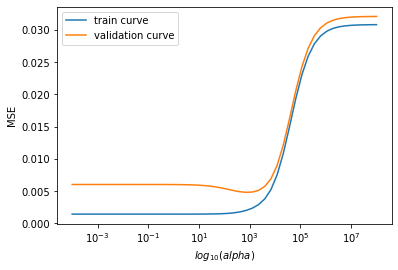

In [12]:
# Plot the validation curves
plt.semilogx(gs_results["alpha"], gs_results["train_mse"], label="train curve")
plt.semilogx(
    gs_results["alpha"], gs_results["validation_mse"], label="validation curve"
)
plt.xlabel("$log_{10}(alpha)$")
plt.ylabel("MSE")
plt.legend()
plt.show()

There are a few things to observe about this result.

* The optimal range of alpha values seems to be around 10e3
* The model starts overfitting when alpha is smaller than 10e2
* The models starts underfitting when alpha is larger than 10e4

It’s also interesting to see that the validation score reaches a plateau with alpha values above 10e6. This is the effect of regularization: when the regularization strength is too large, the model coefficient go to zero and the model always predicts the intercept term.



In [13]:
# Fit a model with a very strong regularization
strong_ridge = Ridge(alpha=10 ** 10)
strong_ridge.fit(X_tr_rescaled, y_tr)

print("Largest coefficient: {:.1e}".format(np.max(np.abs(strong_ridge.coef_))))
print("Intercept: {:.2f}".format(strong_ridge.intercept_))

Largest coefficient: 1.8e-08
Intercept: 5.23


Since all coefficients are close to zero, the model always predicts the intercept term - 5.23 in this case. It’s interesting to observe that this is equal to the mean - which is, as we saw in a previous unit, the constant prediction that minimizes the MSE score i.e. the mean baseline.

In [14]:
print("Mean target value: {:.2f}".format(np.mean(y_tr)))

Mean target value: 5.23


On the left part of the plot, the model also reaches a plateau which corresponds to the performance of a non-regularized model without the numerical issues that we encountered above. It’s interesting to note that a very small regularization factor can already solve those numerical issues in this case.

Let’s retrieve the alpha with the best generalization i.e. the one that minimizes the validation score.

In [15]:
# Get entry with the best validation MSE
best_result = gs_results.loc[gs_results.validation_mse.idxmin()]

# Print the details
print("Best alpha: {:.1e}".format(best_result.alpha))
print("Validation MSE: {:.4f}".format(best_result.validation_mse))
print("Validation MAE: {:,.0f}$".format(best_result.validation_mae))

Best alpha: 7.2e+02
Validation MSE: 0.0048
Validation MAE: 15,597$


#### Introduction to cross-validation
In the code from above, we found the best alpha value for a single train/validation set split. This result shouldn’t be too far from the true optimal alpha value since the train/validation scores are evaluated on a large set of data points. However, it’s often a good idea to average the scores on different train/validation splits to get more stable results. This is called cross-validation.

We will learn more about the different cross-validation variants in the next course, but let’s implement our own cross-validation strategy with a simple for loop.



In [16]:
# Fit/validate N models
gs_results = []
for run_idx in range(10):

    # Split into train/validation sets
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.5, random_state=run_idx
    )

    # Standardize features
    X_tr_rescaled = scaler.fit_transform(X_tr)
    X_val_rescaled = scaler.transform(X_val)

    # Grid search
    for alpha in np.logspace(1, 4, num=20):
        # Create and fit ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_tr_rescaled, y_tr)

        # Save model and its performance on train/validation sets
        gs_results.append(
            {
                "model": ridge,
                "alpha": alpha,
                "run_idx": run_idx,
                "train_mse": MSE(y_tr, ridge.predict(X_tr_rescaled)),
                "train_mae": MAE(10 ** y_tr, 10 ** ridge.predict(X_tr_rescaled)),
                "validation_mse": MSE(y_val, ridge.predict(X_val_rescaled)),
                "validation_mae": MAE(10 ** y_val, 10 ** ridge.predict(X_val_rescaled)),
            }
        )

In this code, we perform grid search on 10 different train/validation splits by changing the random_state attribute. For each different split, we standardize the data using the train mean and standard deviations.

The gs_results now contains 10 times more entries than if we had used a single train/validation set split.

In [17]:
# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,model,alpha,run_idx,train_mse,train_mae,validation_mse,validation_mae
0,Ridge(alpha=10.0),10.000000,0,0.001416,11151.125598,0.005898,17485.758076
1,Ridge(alpha=14.38449888287663),14.384499,0,0.001419,11161.657456,0.005857,17372.165040
2,Ridge(alpha=20.6913808111479),20.691381,0,0.001424,11176.962177,0.005802,17233.571836
3,Ridge(alpha=29.76351441631318),29.763514,0,0.001431,11198.863815,0.005733,17067.620448
4,Ridge(alpha=42.81332398719393),42.813324,0,0.001442,11233.772529,0.005647,16871.527796


Let’s group the results by alpha value and compute the average scores.

In [18]:
# Group results by alpha value
gb_alpha = gs_results.groupby("alpha")

# Compute train/validation mean scores with std
mean_tr = gb_alpha.train_mse.mean()
mean_val = gb_alpha.validation_mse.mean()
std_tr = gb_alpha.train_mse.std()
std_val = gb_alpha.validation_mse.std()
alphas = mean_tr.index.values

# Get entry with the best mean validation MSE
best_alpha = mean_val.idxmin()
best_result = gb_alpha.get_group(best_alpha)

# Print the details
print("Best alpha: {:.1e}".format(best_alpha))
print("Validation MSE: {:.4f}".format(best_result.validation_mse.mean()))
print("Validation MAE: {:,.0f}$".format(best_result.validation_mae.mean()))

Best alpha: 5.5e+02
Validation MSE: 0.0038
Validation MAE: 15,700$


This time, the best alpha value is 5.5e+02 with a mean validation MSE of 0.0038 and a mean validation MAE of 15,700 dollars which is not far from the values computed above.

Note that we also computed the standard deviation for the different alpha values to measure how much the scores vary around the mean. We can now include this information in the plot with the validation curves.

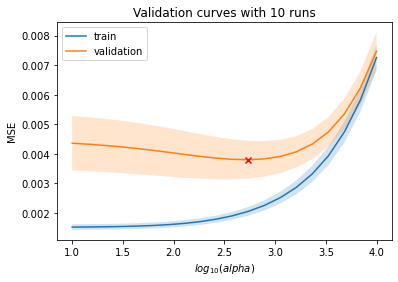

In [19]:
# Plot mean scores
plt.plot(np.log10(alphas), mean_tr, label="train")
plt.plot(np.log10(alphas), mean_val, label="validation")

# Quantify variance with ±std curves
plt.fill_between(np.log10(alphas), mean_tr - std_tr, mean_tr + std_tr, alpha=0.2)
plt.fill_between(np.log10(alphas), mean_val - std_val, mean_val + std_val, alpha=0.2)

# Add marker for best score
plt.scatter(np.log10(best_alpha), mean_val.min(), marker="x", c="red", zorder=10)

plt.title("Validation curves with {} runs".format(len(gs_results.groupby("run_idx"))))
plt.xlabel("$log_{10}(alpha)$")
plt.ylabel("MSE")
plt.legend()
plt.show()